In [1]:
import sys
from timeit import timeit
import pickle

import numpy as np
from scipy.optimize import root_scalar

from matplotlib import pyplot as plt, colors, cm

from tqdm import tqdm

sys.path.append('..')
from sketched.sketched import DiscreteSpectrum, SketchedEquivalence

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}\usepackage{amsfonts}')
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

#color_cycle = ['#003366', '#990000', '#669900']
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def find_alpha_for_mu_0(spectrum, mu):
    
    def f(alpha):
        return SketchedEquivalence(spectrum, alpha).mu_0 - mu
    
    res = root_scalar(f, method='brentq', bracket=(1e-6, 1e6))
    return res.root

In [4]:
p = 500
n = p * 2
r = 1 / 2
rp = int(r * p)

In [5]:
p_lsl = 5000
n_lsl = p_lsl * n // p
rp_lsl = int(r * p_lsl)
X = np.random.randn(n_lsl, p_lsl)
X[:, rp_lsl:] = 0
lsl_eigvals = np.linalg.eigvalsh(X.T @ X / n)
lsl_eigvals[:-rp_lsl] = 0
lsl_spectrum = DiscreteSpectrum(lsl_eigvals)

In [6]:
mus = [-0.01, 0.01, 0.1, 1, 10]
alphas = np.linspace(find_alpha_for_mu_0(lsl_spectrum, max(mus)), 1, 150)
alpha_tol = 1e-3
sigma = np.sqrt(0.1)
B = 1
n_trials = 50

each_alphas = []
trials = []

/home/daniel/mnt/3tb0.ext40/tatooine/rice/src/sketched-pseudoinverse/experiments/../sketched/sketched.py:106: RuntimeWarning: divide by zero encountered in true_divide
  return self.weights @ (self.eigvals ** num_deg / (self.eigvals - zeta) ** denom_deg)


In [7]:
with tqdm(range(n_trials)) as pbar1, tqdm() as pbar2, tqdm() as pbar3:
    
    for t in range(n_trials):
        
        pbar1.set_description(f'{t=}')
    
        X = np.random.randn(n, p)
        X[:, rp:] = 0
        beta_gt = np.random.randn(p) / np.sqrt(p)
        y = X @ beta_gt + sigma * np.random.randn(n)

        beta_ridges = []
        beta_hats = []
        
        pbar2.reset(total=len(mus))

        for i, mu in enumerate(mus):

            beta_hats.append([])

            pbar2.set_description(f'{mu=:g}')
            
            alpha0 = find_alpha_for_mu_0(lsl_spectrum, mu)
            these_alphas = np.concatenate(([alpha0 + alpha_tol], alphas[alphas > alpha0 + alpha_tol]))
            
            if mu == 0:
                beta_ridge = np.linalg.pinv(X) @ y 
            else:
                beta_ridge = np.linalg.solve(X.T @ X / n + mu * np.eye(p), X.T @ y / n)

            beta_ridges.append(beta_ridge)

            if t == 0:
                each_alphas.append(these_alphas)
                
            pbar3.reset(total=len(these_alphas))

            for j, alpha in enumerate(these_alphas):

                q = int(alpha * p)
                K = int(B / alpha ** 2)
                lamda = SketchedEquivalence(lsl_spectrum, alpha).get_lamda_from_mu(mu)

                pbar3.set_description(f'{alpha=:g} {K=}')

                beta_hat = np.zeros(p)

                for k in range(K):

                    S = np.random.randn(p, q) / np.sqrt(q)
                    XS = X @ S

                    beta_hat += S @ np.linalg.solve(XS.T @ XS / n + lamda * np.eye(q), XS.T @ y / n) / K

                beta_hats[-1].append(beta_hat)
                
                pbar3.update()

            pbar2.update()
            
        trials.append({
            'beta_ridges': beta_ridges,
            'beta_hats': beta_hats
        })

        pbar1.update()
        
with open('efficiency.pkl', 'wb') as f:
    pickle.dump({
        'each_alphas': each_alphas,
        'trials': trials
    }, f)

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [8]:
with open('efficiency.pkl', 'rb') as f:
    data = pickle.load(f)
each_alphas = data['each_alphas']
trials = data['trials']

/home/daniel/mnt/3tb0.ext40/tatooine/rice/src/sketched-pseudoinverse/experiments/../sketched/sketched.py:106: RuntimeWarning: divide by zero encountered in true_divide
  return self.weights @ (self.eigvals ** num_deg / (self.eigvals - zeta) ** denom_deg)
/home/daniel/mnt/3tb0.ext40/tatooine/rice/src/sketched-pseudoinverse/experiments/../sketched/sketched.py:106: RuntimeWarning: divide by zero encountered in true_divide
  return self.weights @ (self.eigvals ** num_deg / (self.eigvals - zeta) ** denom_deg)
/home/daniel/mnt/3tb0.ext40/tatooine/rice/src/sketched-pseudoinverse/experiments/../sketched/sketched.py:106: RuntimeWarning: divide by zero encountered in true_divide
  return self.weights @ (self.eigvals ** num_deg / (self.eigvals - zeta) ** denom_deg)
/home/daniel/mnt/3tb0.ext40/tatooine/rice/src/sketched-pseudoinverse/experiments/../sketched/sketched.py:106: RuntimeWarning: divide by zero encountered in true_divide
  return self.weights @ (self.eigvals ** num_deg / (self.eigvals - 

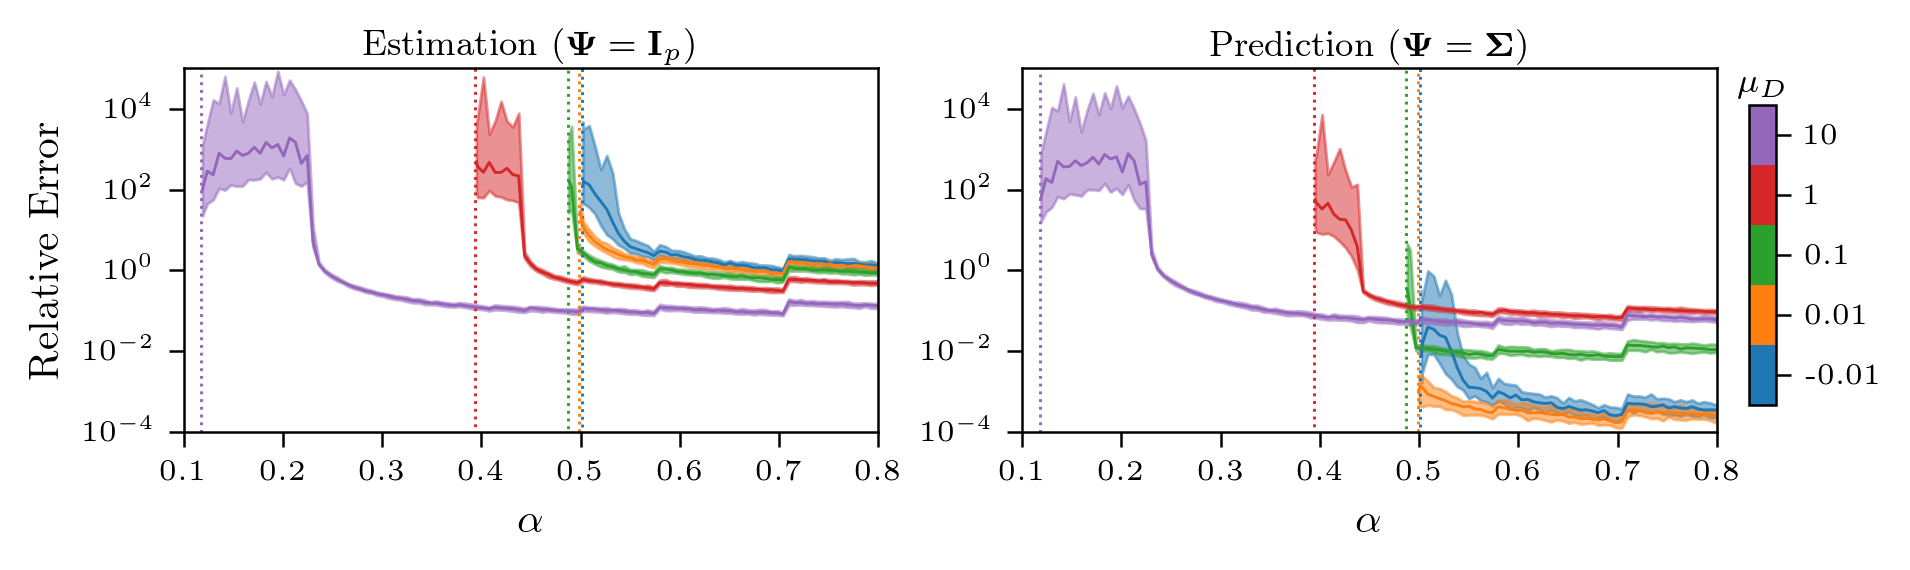

In [9]:
def relative_error(beta_ridge, beta_hat, metric=None):
    
    if metric == 'Sigma':
        return np.linalg.norm(beta_ridge[:rp] - beta_hat[:rp]) ** 2 / np.linalg.norm(beta_ridge[:rp])
    else:
        return np.linalg.norm(beta_ridge - beta_hat) ** 2 / np.linalg.norm(beta_ridge)

def create_cmap_norm_for_ns(n_max):
    
    norm = colors.Normalize(-0.5, n_max - 0.5)
    cmap = colors.ListedColormap(color_cycle[:n_max])
    
    return cmap, norm
    
cmap, norm = create_cmap_norm_for_ns(len(mus))
scalar_map = cm.ScalarMappable(norm, cmap=cmap)
    
fig = plt.figure(figsize=(6, 2), dpi=300)

for i, mu in enumerate(mus):
    
    alpha0 = find_alpha_for_mu_0(lsl_spectrum, mu)
    
    plt.subplot(1, 2, 1)
    plt.plot(np.ones(2) * alpha0, [1e-6 + i / len(mus) * 1e-6, 1e6], ':', color=color_cycle[i])
    
    error1 = np.zeros((n_trials, len(each_alphas[i])))
    for t, trial in enumerate(trials):
        beta_hats = trial['beta_hats']
        beta_ridges = trial['beta_ridges']
        error1[t, :] = np.asarray([relative_error(beta_ridges[i], beta) for beta in beta_hats[i]])
    error1_qt = np.vstack((np.quantile(error1, 0.1, axis=0)[None, :], np.quantile(error1, 0.9, axis=0)[None, :]))
    plt.plot(each_alphas[i], np.median(error1, 0), color=color_cycle[i])
    plt.fill_between(each_alphas[i], error1_qt[0, :], error1_qt[1, :], color=color_cycle[i], alpha=0.5)
    
    plt.subplot(1, 2, 2)
    
    plt.plot(np.ones(2) * alpha0, [1e-6 + i / len(mus) * 1e-6, 1e6], ':', color=color_cycle[i])
    
    error2 = np.zeros((n_trials, len(each_alphas[i])))
    for t, trial in enumerate(trials):
        beta_hats = trial['beta_hats']
        beta_ridges = trial['beta_ridges']
        error2[t, :] = np.asarray([relative_error(beta_ridges[i], beta, metric='Sigma') for beta in beta_hats[i]])
    error2_qt = np.vstack((np.quantile(error2, 0.1, axis=0)[None, :], np.quantile(error2, 0.9, axis=0)[None, :]))
    #plt.errorbar(each_alphas[i], np.mean(error2, 0), abs(error2_qt - np.mean(error2, 0)[None, :]))
    plt.plot(each_alphas[i], np.median(error2, 0), color=color_cycle[i])
    plt.fill_between(each_alphas[i], error2_qt[0, :], error2_qt[1, :], color=color_cycle[i], alpha=0.5)

ylim = 1e-4, 1e5
xlim = 0.1, 0.8

plt.subplot(1, 2, 1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale('log')
plt.minorticks_off()

plt.title(r'Estimation (${\bm \Psi} = \mathbf{I}_p$)', pad=3)
plt.xlabel(r'$\alpha$')
plt.ylabel('Relative Error')
#plt.ylabel(r'$\cfrac{\mathcal{E}_{\bm \Psi}(\widehat{\bm \beta}_D^\mathrm{ens}, \widehat{\bm \beta}_D^\mathrm{ridge})}' + \
#    r'{\mathcal{E}_{\bm \Psi}(\mathbf{0}, \widehat{\bm \beta}_D^\mathrm{ridge})}$', rotation=0, labelpad=40)
#plt.text(-0.285, 0.8, 'Relative Error')
#plt.text(-0.3, 0.025, r'$\cfrac{\mathcal{E}_{\bm \Psi}(\widehat{\bm \beta}_D^\mathrm{ens}, \widehat{\bm \beta}_D^\mathrm{ridge})}' + \
#    r'{\mathcal{E}_{\bm \Psi}(\mathbf{0}, \widehat{\bm \beta}_D^\mathrm{ridge})}$')

plt.subplot(1, 2, 2)
plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale('log')
plt.minorticks_off()

#plt.title(r'${\bm \Psi} = \mathbb{E}\big[\tfrac{1}{n} \textbf{X}^\top \textbf{X}\big]$', pad=5)
plt.title(r'Prediction (${\bm \Psi} = {\bm \Sigma}$)', pad=3)
plt.xlabel(r'$\alpha$')

ax = fig.add_axes([0.98, 0.3, 0.015, 0.5])
cbar = plt.colorbar(scalar_map, cax=ax, ticks=np.arange(len(mus)), pad=0.01)
cbar.ax.set_yticklabels(mus)
cbar.ax.set_title(r'$\mu_D$')

plt.tight_layout(w_pad=0.5)
plt.savefig('efficiency.pdf', bbox_inches='tight')
plt.show()

In [10]:
find_alpha_for_mu_0(lsl_spectrum, 0.1)

/home/daniel/mnt/3tb0.ext40/tatooine/rice/src/sketched-pseudoinverse/experiments/../sketched/sketched.py:106: RuntimeWarning: divide by zero encountered in true_divide
  return self.weights @ (self.eigvals ** num_deg / (self.eigvals - zeta) ** denom_deg)


0.48699915915314707

In [11]:
SketchedEquivalence(lsl_spectrum, 0.49).mu_0

0.0764492445196919

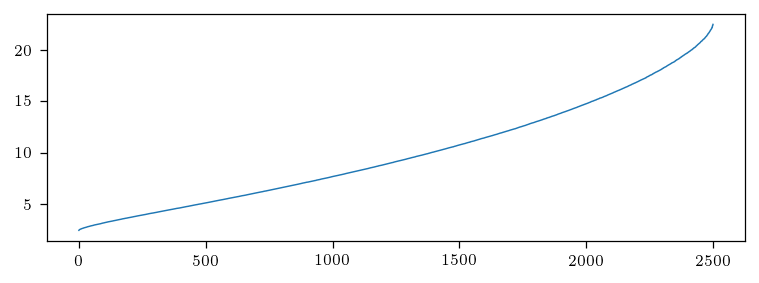

In [12]:
plt.plot(lsl_spectrum.eigvals[2500:])

In [13]:
each_alphas[4].min()

0.11905441066105013